In [1]:
%matplotlib inline

In [202]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ontology_utils import load_abstract_trees
from ontology_utils import OntologyBranch

def draw_connection_matrix(nodes):
    conn = np.zeros((len(nodes), len(nodes)))
    for node in nodes:
        for parent in node.parents:
            conn[parent.idx, node.idx] = 1
    return conn
    
def nx_create_random_cycle(G, node, depth):
    if len(G.neighbors(node)) > 0:
        current = node
        for i in range(depth):
            tries = 5
            while True:
                sampled = random.sample(G.neighbors(current), 1)[0]
                if len(G.neighbors(sampled)) == 0 or sampled == current:
                    tries -= 1
                    if tries == 0:
                        return False
                    continue
                else:
                    break
                    
            current = sampled
        
        G.add_edge(current, node)
        return True
    else:
        return False

def random_wiki_graph(size, prob_reconnect, cycles=0, cycle_depth=2):
    G = nx.DiGraph()
    
    current = [0]
    G.add_node(0)
    lower_level = []
    
    for i in range(1, size):
        G.add_node(i)
        G.add_edge(i, random.sample(current,1)[0])
        lower_level.append(i)
        if random.random() > prob_reconnect:
            current = lower_level
    
    for cycle in range(cycles):
        while True:
            sampled = random.sample(G.nodes(), 1)[0]
            cycle_success = nx_create_random_cycle(
                G,
                sampled,
                cycle_depth
            )
            if cycle_success:
                break
                
                
    return G

import networkx as nx

def get_leaves(graph):
    return list(n for n,d in G.in_degree_iter() if d==0)

def get_roots(graph):
    return list(n for n,d in G.out_degree_iter() if d==0)

def get_common_edges(G, cycles=None):
    if cycles is None:
        cycles = list(nx.simple_cycles(G))
    
    common_edges = {}
    
    for cycle in cycles:
        cycle = cycle
        
        for i in range(len(cycle)):
            edge = (cycle[i], cycle[(i+1) % len(cycle)])
        
            if edge in common_edges:
                common_edges[edge] += 1
            else:
                common_edges[edge] = 1
    return common_edges


def edge_in_cycle(cycle, edge):
    for i in range(len(cycle)):
        some_edge = (cycle[i], cycle[(i+1) % len(cycle)])
        if edge == some_edge:
            return True
    return False


def greedy_remove_cycles(G, max_cycles=np.inf, blacklist=None, verbose=False):
    if blacklist is None:
        blacklist = set()
    if verbose:
        print("Finding simple cycles", flush=True)
    cycles, common_edges = simple_cycles(G, max_cycles, blacklist)
    if verbose:
        print("Done.", flush=True)
    removals = []
    
    while len(cycles) > 0:
        G_copy = G.copy()
        
        edge, val = max(common_edges.items(), key=lambda x: x[1])
        del common_edges[edge]
        
        G_copy.remove_edge(*edge)
        
        is_connected = root_can_reach_all(G_copy)
        
        if is_connected:
            removals.append(edge)
            G = G_copy
            
            out_cycles = []
            for cycle in cycles:
                if not edge_in_cycle(cycle, edge):
                    out_cycles.append(cycle)
            
            cycles = out_cycles
            if verbose:
                print("%d cycles left" % (len(cycles),), flush=True)
        else:
            blacklist.add(edge)
            
    return G, removals

def root_can_reach_all(G):
    root = get_roots(G)[0]
    visited = {root}
    queue = [root]
    
    while len(queue) > 0:
        new_queue = []
        for node in queue:
            for neighbor in G.predecessors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    new_queue.append(neighbor)
                    
        queue = new_queue
    if len(visited) != len(G):
        return False
    return True
    


In [24]:
def extract_subgraph(node_names, lookup_table):
    name2node = {}
    for node_name in node_names:
        name2node[node_name] = OntologyBranch(node_name)
        
    
    for node_name, node in name2node.items():
        original_node = lookup_table[node_name]
        node.parents = [name2node[parent.name]
                        for parent in original_node.parents
                        if parent.name in name2node]
        node.children = [name2node[child.name]
                         for child in original_node.children
                         if child.name in name2node]
    
    return name2node

def convert_ontology_to_digraph(nodes):
    graph = nx.DiGraph()
    
    for node in nodes.values():
        graph.add_node(node.name)
        for parent in node.parents:
            graph.add_edge(node.name, parent.name)
        
            
    return graph

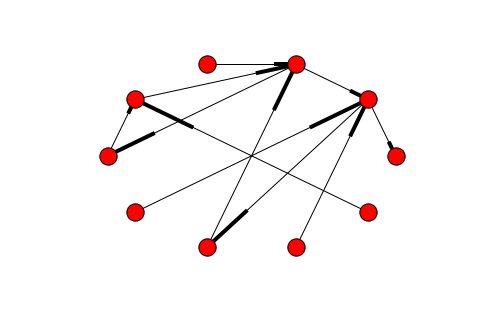

In [80]:
G = random_wiki_graph(10, 0.3, 2)
pos = nx.layout.circular_layout(G)
nx.draw(G, pos=pos)

In [203]:
#onto = load_abstract_trees("/Users/jonathanraiman/Desktop/datasets/full_wiki_export/ontology.txt.gz")
#with open("ancestors.txt", "rt") as f:
#    ancestors = set([l.strip("\n") for l in f]) | {'Category:Main topic classifications'}
#extracted = extract_subgraph(ancestors, onto[0].lookup_table)
G = convert_ontology_to_digraph(extracted)

In [121]:
for key in extracted:
    if len(extracted[key].children) == 0:
        break

In [123]:
extracted[key].parents

[<Branch name="Category:History of Europe by region", num_children=6, num_parents=2>,
 <Branch name="Category:History of the Netherlands", num_children=18, num_parents=3>,
 <Branch name="Category:History of Belgium", num_children=14, num_parents=3>,
 <Branch name="Category:History of Luxembourg", num_children=5, num_parents=3>]

In [ ]:
node2idx = {name : k for k, name in enumerate(G)}

In [101]:
import numpy as np

In [104]:
#with open("graph_out.txt", "wt") as f:
arr = np.zeros((G.number_of_edges(), 2), dtype=np.int32)
for edge_idx, edge in enumerate(G.edges_iter()):
    arr[edge_idx, :] = [node2idx[edge[0]], node2idx[edge[1]]]
arr.tofile("graph_out.bin")

In [106]:
arr[1]

array([   0, 1024], dtype=int32)

In [74]:
newG, removals = greedy_remove_cycles(G, True)

Finding simple cycles


KeyboardInterrupt: 

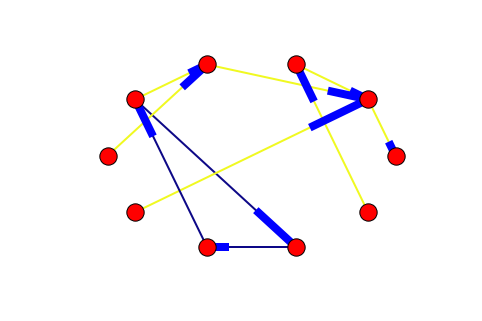

In [172]:
nx.draw(G,
        edge_color=[
            edges[edge] if edge in edges else 0.5 for edge in G.edges()
        ],
        width=2,
        arrows=True,
        edge_cmap=plt.cm.plasma_r,
        pos=pos
       )

In [42]:
import time

In [51]:
vals = np.zeros((100, 7))
vals.fill(-1)

for n in range(10, 100):
    for num_cycle in range(1, 6):
        t0 = time.time()
        G = random_wiki_graph(n, 0.3, num_cycle)
        newG, removals= greedy_remove_cycles(G)
        t0 = time.time() - t0
        vals[n, num_cycle] = t0

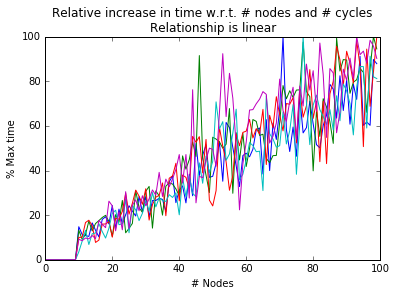

In [56]:
for i in range(vals.shape[1]):
    col = vals[:,i]
    if any(col > -1):
        plt.plot(np.arange(vals.shape[0]), 100.0 * np.maximum(col, 0) / col.max())
plt.title("Relative increase in time w.r.t. # nodes and # cycles\nRelationship is linear")
plt.xlabel("# Nodes")
plt.ylabel("% Max time");

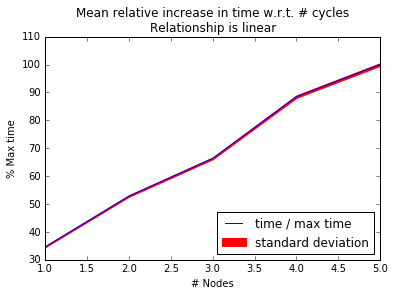

In [63]:
mean_col = []

for i in range(vals.shape[0]):
    col = vals[i,:]
    if any(col > -1):
        col = col[ col > -1]
        mean_col.append(col)
        
mean_col = np.vstack(mean_col)
col = mean_col.mean(axis=0)
x = np.arange(1, len(col) + 1)
y = col / col.max()
plt.plot(x, 100.0 * y, label="time / max time")
error = np.std(mean_col, axis=0)
plt.fill_between(x, 100.0 * (y-error), 100.0 * (y+error), color="red", label="standard deviation")
plt.title("Mean relative increase in time w.r.t. # cycles\nRelationship is linear")
plt.xlabel("# Nodes")
plt.ylabel("% Max time");
plt.legend(loc="lower right");

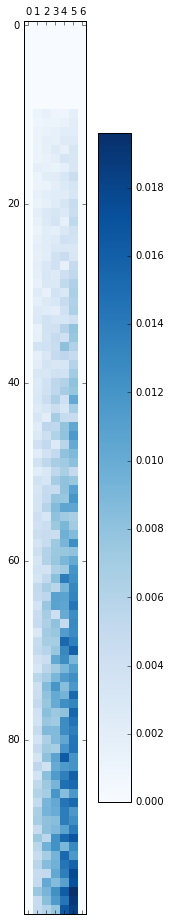

In [48]:
plt.matshow(np.maximum(vals, 0), cmap=plt.cm.Blues)
plt.colorbar()

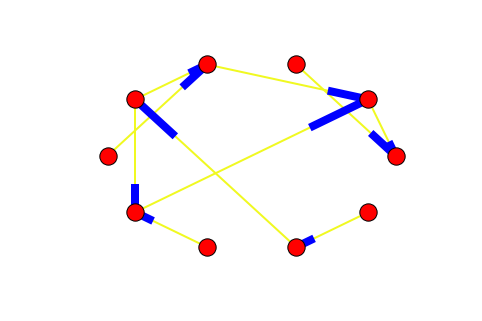

In [174]:
nx.draw(newG,
        edge_color=[
            edges[edge] if edge in edges else 0.5 for edge in newG.edges()
        ],
        width=2,
        arrows=True,
        edge_cmap=plt.cm.plasma_r,
        pos=pos
       )

In [65]:
root_can_reach_all(G)

True

In [66]:
edges = get_common_edges(newG)

In [113]:
G = nx.DiGraph()
G.add_node(0)
G.add_node(1)
G.add_node(3)
G.add_edge(0, 1)
G.add_edge(1, 3)
G.add_edge(3, 0)

In [185]:
from collections import defaultdict

def simple_cycles(G, max_cycles, blacklist=None):
    """Find simple cycles (elementary circuits) of a directed graph.

    An simple cycle, or elementary circuit, is a closed path where no
    node appears twice, except that the first and last node are the same.
    Two elementary circuits are distinct if they are not cyclic permutations
    of each other.

    This is a nonrecursive, iterator/generator version of Johnson's
    algorithm [1]_.  There may be better algorithms for some cases [2]_ [3]_.

    Parameters
    ----------
    G : NetworkX DiGraph
       A directed graph

    Returns
    -------
    cycle_generator: generator
       A generator that produces elementary cycles of the graph.  Each cycle is
       a list of nodes with the first and last nodes being the same.

    Examples
    --------
    >>> G = nx.DiGraph([(0, 0), (0, 1), (0, 2), (1, 2), (2, 0), (2, 1), (2, 2)])
    >>> len(list(nx.simple_cycles(G)))
    5

    To filter the cycles so that they don't include certain nodes or edges,
    copy your graph and eliminate those nodes or edges before calling

    >>> copyG = G.copy()
    >>> copyG.remove_nodes_from([1])
    >>> copyG.remove_edges_from([(0, 1)])
    >>> len(list(nx.simple_cycles(copyG)))
    3


    Notes
    -----
    The implementation follows pp. 79-80 in [1]_.

    The time complexity is `O((n+e)(c+1))` for `n` nodes, `e` edges and `c`
    elementary circuits.

    References
    ----------
    .. [1] Finding all the elementary circuits of a directed graph.
       D. B. Johnson, SIAM Journal on Computing 4, no. 1, 77-84, 1975.
       http://dx.doi.org/10.1137/0204007
    .. [2] Enumerating the cycles of a digraph: a new preprocessing strategy.
       G. Loizou and P. Thanish, Information Sciences, v. 27, 163-182, 1982.
    .. [3] A search strategy for the elementary cycles of a directed graph.
       J.L. Szwarcfiter and P.E. Lauer, BIT NUMERICAL MATHEMATICS,
       v. 16, no. 2, 192-204, 1976.

    See Also
    --------
    cycle_basis
    """
    def _unblock(thisnode,blocked,B):
        stack=set([thisnode])
        while stack:
            node=stack.pop()
            if node in blocked:
                blocked.remove(node)
                stack.update(B[node])
                B[node].clear()

    # Johnson's algorithm requires some ordering of the nodes.
    # We assign the arbitrary ordering given by the strongly connected comps
    # There is no need to track the ordering as each node removed as processed.
    subG = type(G)(G.edges_iter()) # save the actual graph so we can mutate it here
                              # We only take the edges because we do not want to
                              # copy edge and node attributes here.
    sccs = list(nx.strongly_connected_components(subG))
    
    common_edges = {}
    max_edge = 0
    
    if blacklist is None:
        blacklist = set()
    
    paths = []
    
    while sccs:
        scc=sccs.pop()
        # order of scc determines ordering of nodes
        startnode = scc.pop()
        # Processing node runs "circuit" routine from recursive version
        path=[startnode]
        blocked = set() # vertex: blocked from search?
        closed = set() # nodes involved in a cycle
        blocked.add(startnode)
        B=defaultdict(set) # graph portions that yield no elementary circuit
        stack=[ (startnode,list(subG[startnode])) ]  # subG gives component nbrs
        while stack:
            thisnode,nbrs = stack[-1]
            if nbrs:
                nextnode = nbrs.pop()
                if nextnode == startnode:
                    paths.append(path[:])
                    closed.update(path)
                    
                    for i in range(len(path)):
                        edge = (path[i], path[(i+1) % len(path)])

                        if edge in common_edges:
                            common_edges[edge] += 1
                            max_edge = max(common_edges[edge], max_edge)
                        else:
                            if edge not in blacklist:
                                common_edges[edge] = 1
                            
                    if len(paths) % 10 == 0:
                        clear_output(wait=True)
                        print("%d paths found. %d common_edges. %d max_edge" % (len(paths), len(common_edges), max_edge))
                    
                    if len(paths) >= max_cycles:
                        return (paths, common_edges)
                    
                elif nextnode not in blocked:
                    path.append(nextnode)
                    stack.append( (nextnode,list(subG[nextnode])) )
                    closed.discard(nextnode)
                    blocked.add(nextnode)
                    continue
            # done with nextnode... look for more neighbors
            if not nbrs:  # no more nbrs
                if thisnode in closed:
                    _unblock(thisnode,blocked,B)
                else:
                    for nbr in subG[thisnode]:
                        if thisnode not in B[nbr]:
                            B[nbr].add(thisnode)
                stack.pop()
                path.pop()
        # done processing this node
        subG.remove_node(startnode)
        H=subG.subgraph(scc)  # make smaller to avoid work in SCC routine
        sccs.extend(list(nx.strongly_connected_components(H)))
    return (paths, common_edges)

In [182]:
cycles = simple_cycles(G, 10000)

10000 paths found. 441 common_edges. 10000 max_edge


In [ ]:
blacklist = set()

iteration = 0
all_removals = []
while True:
    iteration += 1
    print("iteration %d" % (iteration,))
    newG, removals = greedy_remove_cycles(G, 10000, blacklist, verbose=True)
    G = newG
    
    if len(removals) == 0:
        break
    else:
        all_removals.append(removals)

8990 paths found. 527 common_edges. 8990 max_edge


In [190]:
removals

[('Category:Evolution of tetrapods', 'Category:Evolution of animals')]